In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Manejo de Datos Faltantes: Imputación


## Configuración de ambiente de trabajo

```Python
pip install --upgrade pip
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
or

pip install -r requirements.txt
```


## Importar librerías


In [3]:
import janitor
import matplotlib.pyplot as plt
import missingno as msno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas


In [4]:
%run ../imputacion_packages/utils/pandas-missing-extension.py

## Configurar el aspecto general de las gráficas del proyecto


In [5]:
%matplotlib inline

sns.set_theme(style="whitegrid", context='notebook', palette="colorblind")

plt.rcParams['figure.figsize'] = (12, 8)

plt.style.use('ggplot')

## El problema de trabajar con valores faltantes


In [6]:
airquality_df = sm.datasets.get_rdataset("airquality", "datasets").data

# Limpiar los nombres de las columnas y convertirlos a snake_case
airquality_df.columns = airquality_df.columns.str.replace(".", "_").str.lower()

# Añadir la columna 'year' con el valor 1973
airquality_df = airquality_df.assign(year=1973)

# Crear una columna 'date' a partir de 'year', 'month', 'day' y convertirla a datetime
airquality_df = airquality_df.assign(
    date=pd.to_datetime(airquality_df[["year", "month", "day"]])
)

# Ordenar el DataFrame por la columna 'date'
airquality_df = airquality_df.sort_values(by="date")

# Establecer la columna 'date' como índice del DataFrame
airquality_df = airquality_df.set_index("date")

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [7]:
# temp ~ ozone
(smf.ols(formula="temp ~ ozone", data=airquality_df).fit().summary().tables[0])

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Tue, 02 Apr 2024",Prob (F-statistic):,2.93e-18
Time:,05:06:23,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [8]:
# temp ~ ozone + solar_r
(
    smf.ols(formula="temp ~ ozone + solar_r", data=airquality_df)
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Tue, 02 Apr 2024",Prob (F-statistic):,1.47e-16
Time:,05:06:23,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


Vemos que en el dataset original teníamos 153 observaciones, luego cuando medimos la temperatura contra el ozono se redujo a 116 observaciones y cuando medimos el modelo de temperatura con las variables ozono y solar_r el número se redujo a 111 observaciones

Por lo tanto, al crear los modelos perdimos observaciones, dificultando la comparación entre distintos modelos, ya que cada modelo se está ajustando a una cantidad distinta de datos.

Esto se debe a que los algoritmos descartan los valores faltantes.


#### Reto: Datos de supervivientes


In [9]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

In [10]:
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?


In [11]:
(smf.ols(formula="creatinine ~ chapter", data=survival_df).fit().summary().tables[0])

Dep. Variable:,creatinine,R-squared:,0.069
Model:,OLS,Adj. R-squared:,0.061
Method:,Least Squares,F-statistic:,9.560
Date:,"Tue, 02 Apr 2024",Prob (F-statistic):,3.93e-22
Time:,05:06:24,Log-Likelihood:,-1673.6
No. Observations:,1962,AIC:,3379.
Df Residuals:,1946,BIC:,3469.
Df Model:,15,,
Covariance Type:,nonrobust,,


# Preparando datos: National Health and Nutrition Examination Survey


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
Index: 8187 entries, 93703.0 to 102956.0
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   general_health_condition  5797 non-null   object 
 1   age                       8187 non-null   float64
 2   gender                    8187 non-null   object 
 3   height                    5488 non-null   float64
 4   weight                    5553 non-null   float64
 5   diabetes                  8187 non-null   int32  
 6   pulse                     6570 non-null   float64
 7   cholesterol               6565 non-null   float64
dtypes: float64(5), int32(1), object(2)
memory usage: 543.7+ KB


C:\Users\mike\Documents\datos\imputacion\imputacion_packages\utils\pandas-missing-extension.py:269: UserWarning: registration of accessor <class '__main__.Visualization'> under name 'viz' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("viz")


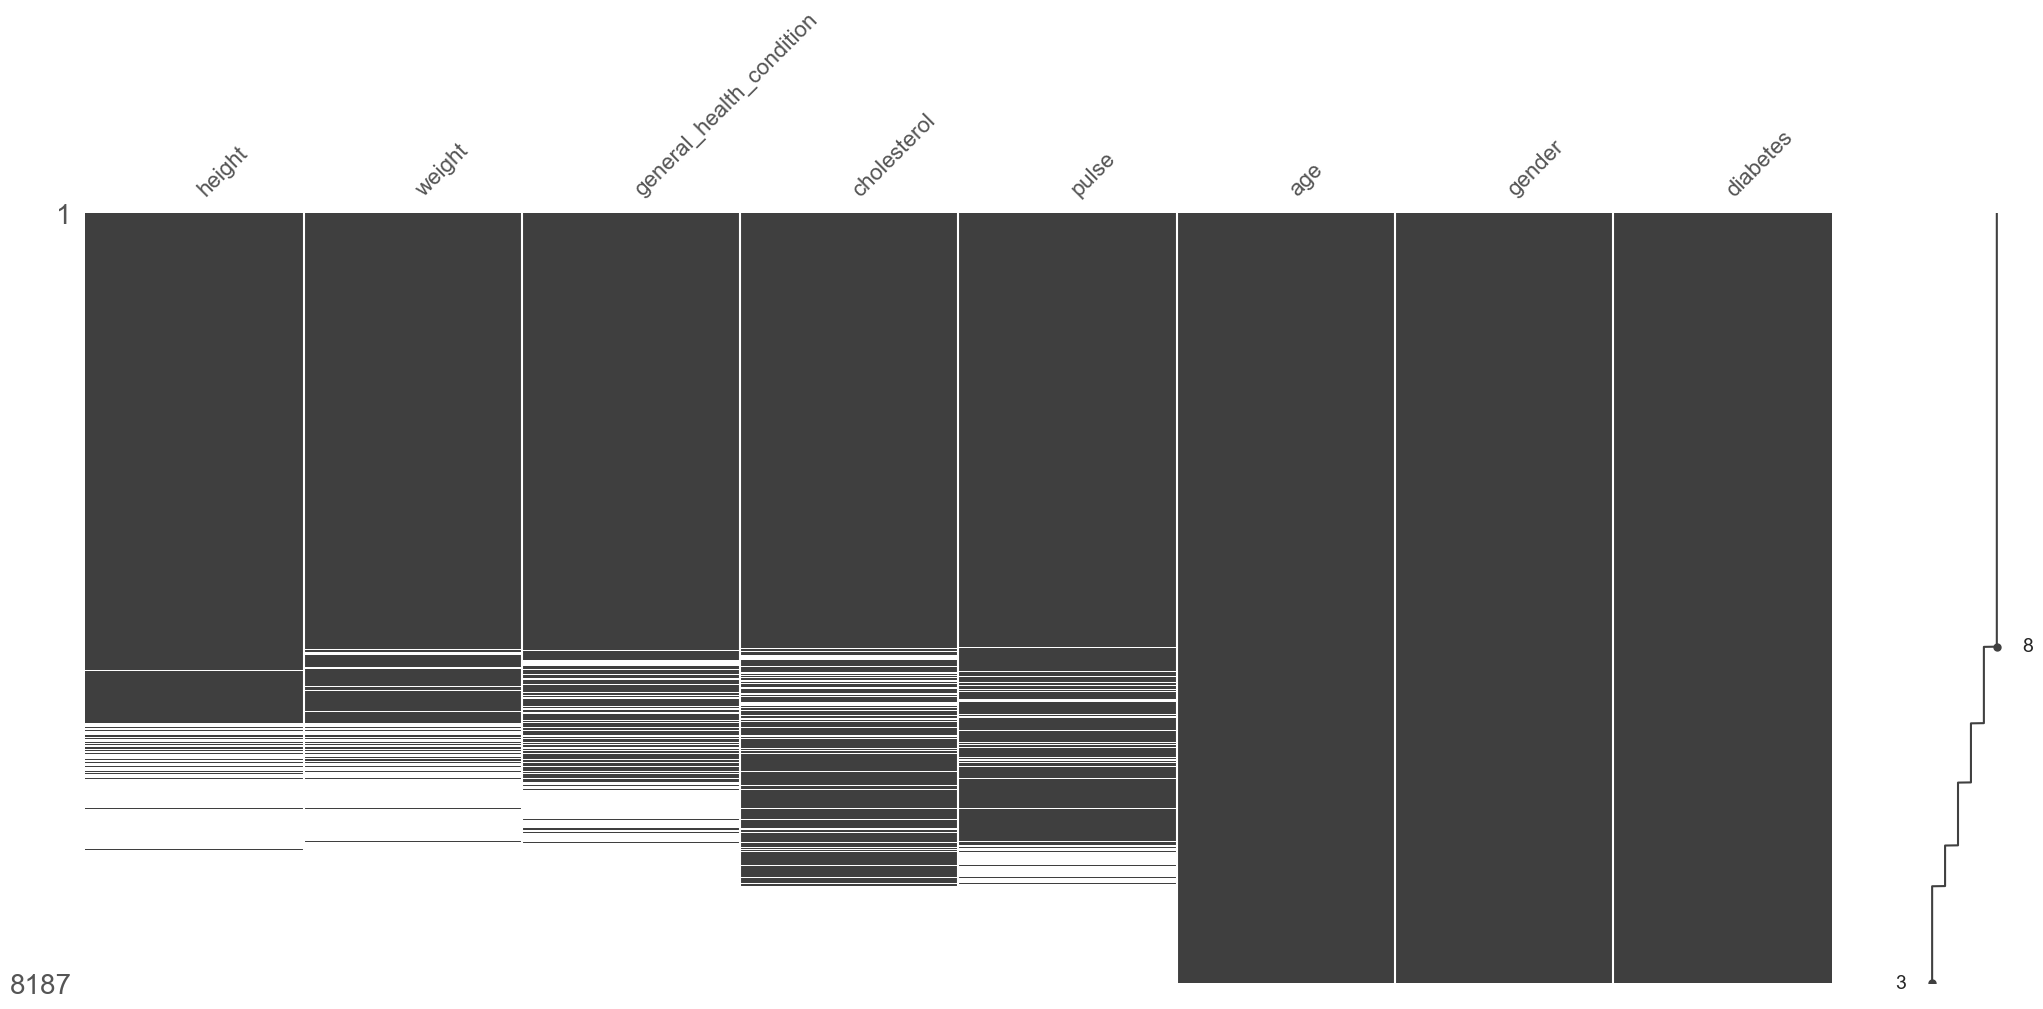

c:\Users\mike\Documents\datos\imputacion\venv\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
c:\Users\mike\Documents\datos\imputacion\venv\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

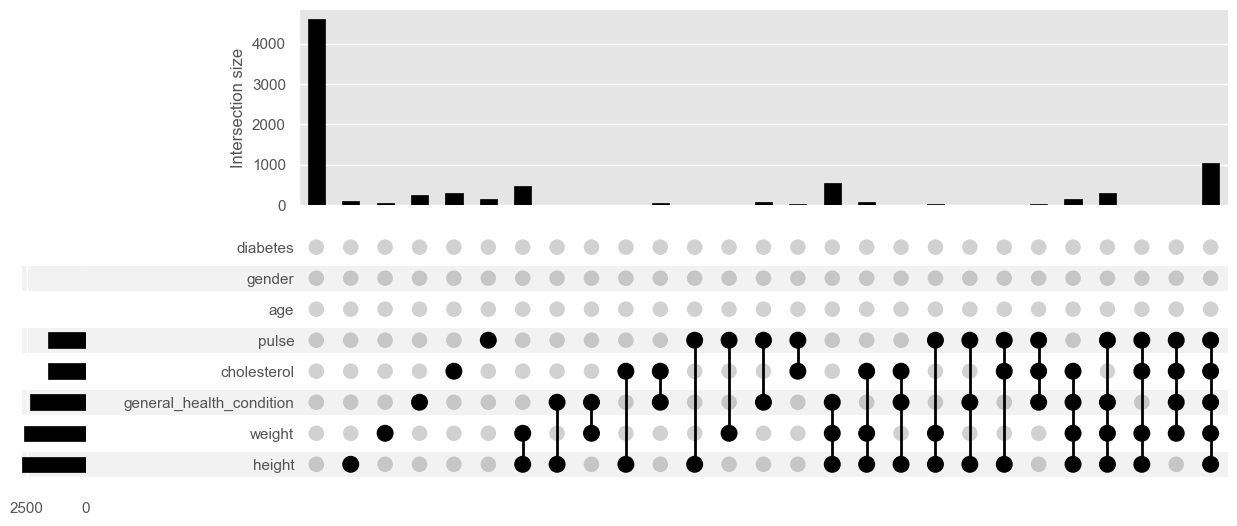

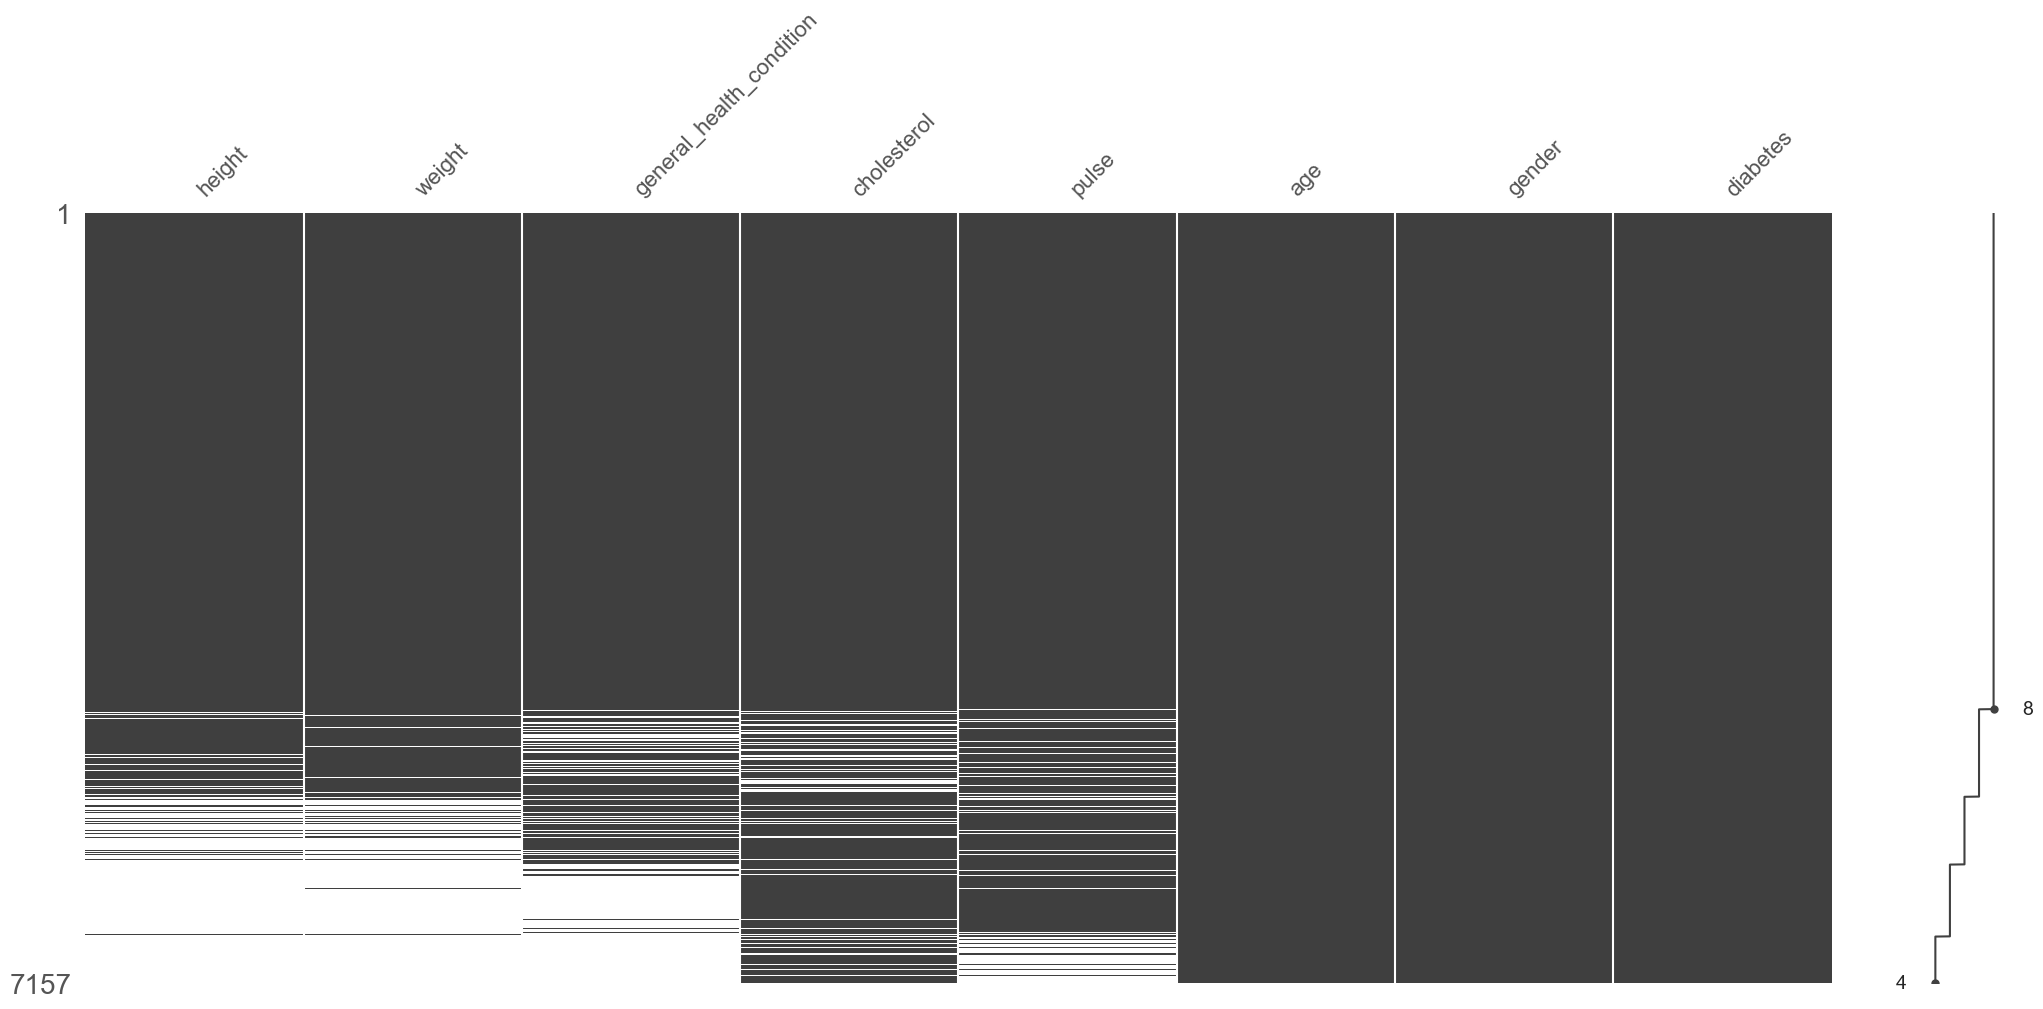

In [12]:
%run ./2.0-M1K3DEV23-download-data-load.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![Complejidad_Valores faltantes](https://raw.githubusercontent.com/mazzaroli/handling_missing_data/ac6b428ee2bdeaf94f143b01d25bca791c7a3667/notebooks/missing_data_action.jpeg)


# MCAR: Evaluación del mecanismo de valores faltantes por prueba de t-test

Define la hipótesis alternativa. Las siguientes opciones están disponibles (la opción predeterminada es "dos caras")

`two-sided`: las **medias** de las distribuciones subyacentes a las muestras son **desiguales**.

`less`: la **media** de la distribución subyacente a la **primera** muestra es **menor** que la media de la distribución subyacente a la **segunda** muestra.

`greater`: la **media** de la distribución subyacente a la **primera** muestra es **mayor** que la media de la distribución subyacente a la **segunda** muestra.

**Hipótesis:**
Analizando los valores del peso ¿Existe alguna diferencia entre la ausencia o presencia de valores faltantes entre mujeres y hombres?

**Hipótesis nula ${h_0}:$**
Si el ${\text pvalue} > 0.5$ no se rechaza la hipótesis nula.

**Hipótesis alternativa ${h_1}:$**
Si el ${\text pvalue} < 0.5$ se rechaza la hipótesis nula.


In [13]:
nhanes_df.head()

,height,weight,general_health_condition,cholesterol,pulse,age,gender,diabetes
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,66.0,Female,0
93706.0,68.0,145.0,Very good,148.0,82.0,18.0,Male,0
93707.0,NaN,NaN,Good,189.0,100.0,13.0,Male,0
93709.0,62.0,200.0,NaN,176.0,74.0,75.0,Female,0
93711.0,69.0,142.0,Very good,238.0,62.0,56.0,Male,0


EL ${\text pvalue == 2.5530}$

Concluimos que los datos del peso entre hombres y mujeres, no están perdidos al azar.


In [14]:
from janitor import select

female_weight, male_weight = (
    nhanes_df.select("gender", "weight")
    .transform_column("weight", lambda x: x.isna(), elementwise=False)
    .groupby("gender")
    .weight.pipe(lambda df: (df.get_group("Female"), df.get_group("Male")))
)

scipy.stats.ttest_ind(a=female_weight, b=male_weight, alternative="two-sided")

TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

EL ${\text pvalue = 0.7172}$

Concluimos que los datos del peso entre hombres y mujeres, no están perdidos al azar.


## Amplía tu conjunto de herramientas para explorar valores faltantes

Explorar relación de variables categóricas en cuestión de ausencia de otra variable


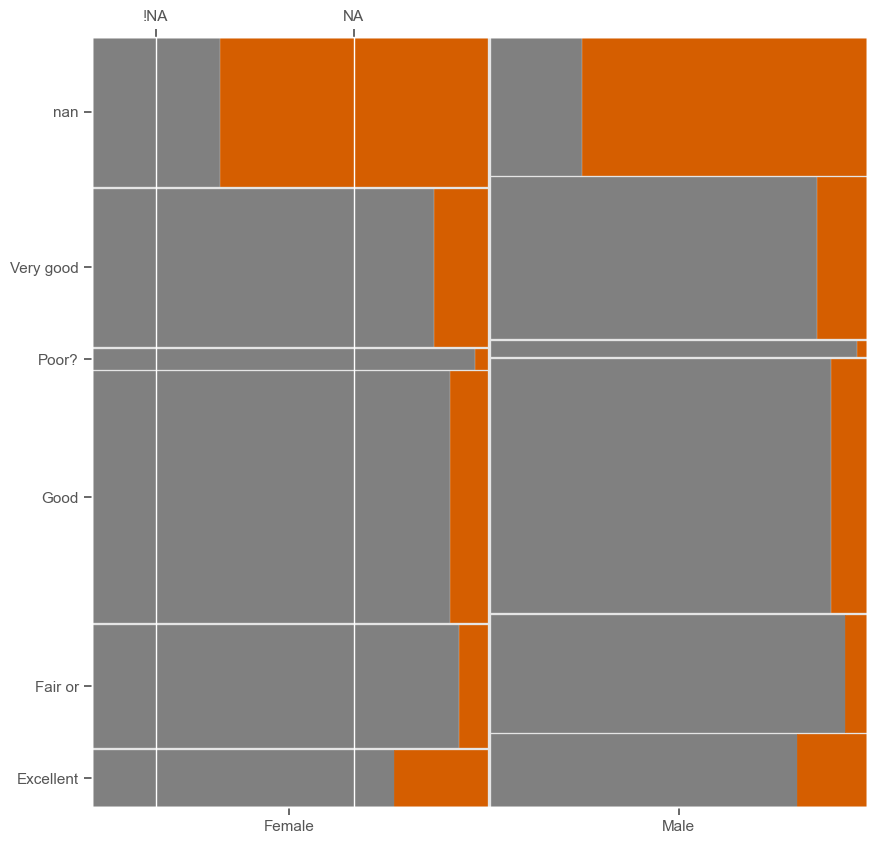

In [15]:
fig, axs = plt.subplots(figsize=(10, 10))

(
    nhanes_df.select("weight", "general_health_condition", "gender")
    .assign(weight=lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"]))
    .groupby(
        ["gender", "general_health_condition", "weight"], dropna=False, as_index=True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color": "r" if "NA" in key else "gray"},
            ax=axs,
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key: "",
        )
    )
)

axs.grid(False)
plt.show()

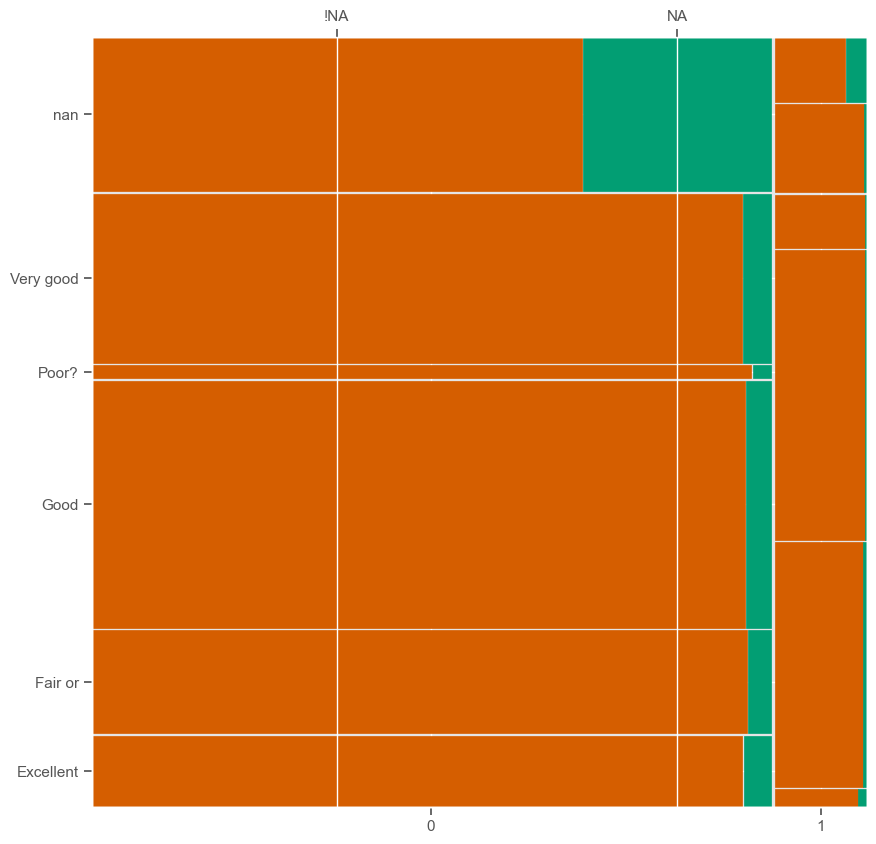

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
nhanes_df.missing.missing_mosaic_plot(
    target_var="pulse",
    x_categorical_var="diabetes",
    y_categorical_var="general_health_condition",
    ax=ax,
)
plt.show()

## Tratamiento de variables categóricas para imputación de valores faltantes


In [17]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

### Codificación ordinal

Información
Una **codificación ordinal** implica mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.


In [18]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [19]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

Una vez ajustamos y transformamos nuestros datos con codificador, podemos hacer uso de su atributo encoder.categories\_ para obtener las categorías únicas de nuestro conjunto de datos.


In [20]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [21]:
encoder.inverse_transform([[1], [0], [0], [1]])

array([['Male'],
       ['Female'],
       ['Female'],
       ['Male']], dtype=object)

### Aplicando la codificación ordinal a todas tus variables categóricas


In [22]:
categorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns

print(categorical_columns)

Index(['general_health_condition', 'gender'], dtype='object')


¿Cuál es el papel de la función `sklearn.compose.make_column_transformer()`?

Transformar cada columna con un transformador asociado a esta y guardar la información necesaria para realizar el procesamiento inverso.


In [23]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough",
)

categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [24]:
# Variables categoricas

# Transformamos las columnas categóricas y creamos un nuevo DataFrame
nhanes_transformed_df = pd.DataFrame(
    categorical_transformer.fit_transform(nhanes_df),
    columns=categorical_transformer.get_feature_names_out(),
    index=nhanes_df.index,
)

# Creamos un diccionario para renombrar las columnas
rename_dict = {
    col: col.removeprefix("ordinalencoder__").removeprefix("remainder__")
    for col in nhanes_transformed_df.columns
}

# Renombramos las columnas utilizando el diccionario
nhanes_transformed_df.rename(columns=rename_dict, inplace=True)

# Mostramos las primeras filas del DataFrame transformado y renombrado
nhanes_transformed_df.head()

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,13.0,0.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0


### One Hot Encoding

**¿Qué es la codificación one-hot encoding?**

Convertirá cada valor categórico en una nueva columna categórica y le asignará un valor binario de 1 o 0 a esas columnas.

**¿Cuándo utilizarías una codificación one-hot en lugar de una codificación ordinal?**

Cuando mis variables categóricas no tienen un orden natural.


In [25]:
nhanes_transformed_onehot_df = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`


#### `pandas.get_dummies()`


In [26]:
(nhanes_transformed_onehot_df.select("general_health_condition").pipe(pd.get_dummies))

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
93709.0,False,False,False,False,False
93711.0,False,False,False,False,True
...,...,...,...,...,...
102949.0,True,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


#### `skelearn.preprocessing.OneHotEncoder()`

**¿Cuál es una ventaja de realizar one-hot encoding utilizando sklearn en lugar de Pandas?**

Realizar one-hot encoding puede llegar a ser más robusto debido a que guarda la información necesaria de las categorías involucradas e incluye una forma de realizar transformaciones inversas.


In [27]:
transformer_one = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough",
)

transformer_one

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 ['gender']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['general_health_condition'])])

In [28]:
# Variables categoricas

# Transformamos las columnas categóricas y creamos un nuevo DataFrame
nhanes_transformed_onehot_df = pd.DataFrame(
    transformer_one.fit_transform(nhanes_df),
    columns=transformer_one.get_feature_names_out(),
    index=nhanes_df.index,
)

# Creamos un diccionario para renombrar las columnas
rename_dict = {
    col: col.removeprefix("ordinalencoder__")
    .removeprefix("remainder__")
    .removeprefix("onehotencoder__")
    for col in nhanes_transformed_onehot_df.columns
}

# Renombramos las columnas utilizando el diccionario
nhanes_transformed_onehot_df.rename(columns=rename_dict, inplace=True)

# Mostramos las primeras filas del DataFrame transformado y renombrado
nhanes_transformed_onehot_df.head(10)

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,13.0,0.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,56.0,0.0
93712.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,68.0,135.0,182.0,68.0,18.0,0.0
93713.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,70.0,165.0,184.0,90.0,67.0,0.0
93714.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,60.0,210.0,230.0,90.0,54.0,1.0
93715.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,68.0,154.0,180.0,66.0,71.0,0.0


In [29]:
print(
    ((transformer_one.named_transformers_).get("ordinalencoder").categories_),
    ((transformer_one.named_transformers_).get("onehotencoder").categories_),
    sep="\n",
)

[array(['Female', 'Male'], dtype=object)]
[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
      dtype=object)]


In [30]:
(
    transformer_one.named_transformers_.get("onehotencoder").inverse_transform(
        X=[[0, 0, 0, 1, 0, 0]]
    )
)

array([['Poor?']], dtype=object)

## Imputación de un único valor (media, mediana, moda)


In [31]:
(
    nhanes_df.transform_column(
        "height", lambda x: x.fillna(x.mean()), elementwise=False
    ).height.mean()
)

66.25655976676386

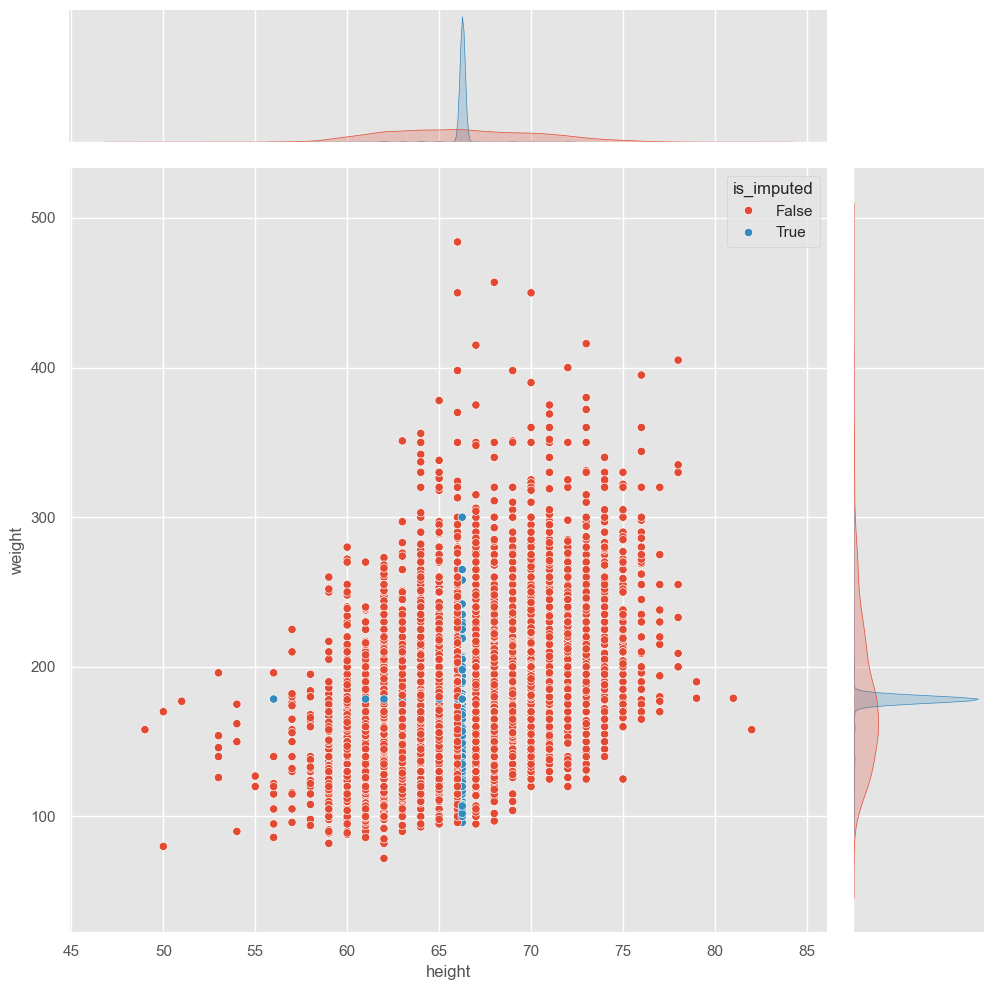

In [32]:
(
    nhanes_df.select("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        # Imputacion por media
        height=lambda df: df.height.fillna(value=df.height.mean()),
        weight=lambda df: df.weight.fillna(value=df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height", y="weight", show_marginal=True, height=10
    )
)
plt.show()

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante (Hot deck imputation & Cold deck imputation)


### `fillna() vs ffill() o bfill()`


In [33]:
(nhanes_df.select("height", "weight"))

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,NaN,NaN
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [34]:
(nhanes_df.select("height", "weight").ffill())

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [35]:
(nhanes_df.select("height", "weight").bfill())

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando ffill() o bfill()

> Imputación dentro de dominios e imputación a través de variables correlacionadas


In [36]:
(
    nhanes_df.select(
        "height", "weight", "gender", "diabetes", "general_health_condition"
    )
    .sort_values(
        by=["gender", "diabetes", "general_health_condition", "weight"], ascending=True
    )
    .transform_column("weight", lambda x: x.ffill(), elementwise=False)
)

,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94195.0,63.0,90.0,Female,0,Excellent
95793.0,61.0,96.0,Female,0,Excellent
101420.0,59.0,98.0,Female,0,Excellent
94148.0,65.0,100.0,Female,0,Excellent
102062.0,62.0,100.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96869.0,72.0,298.0,Male,1,NaN
97267.0,NaN,298.0,Male,1,NaN


In [37]:
(
    nhanes_df.select_columns(
        "height", "weight", "gender", "diabetes", "general_health_condition"
    )
    .sort_values(
        by=["gender", "diabetes", "general_health_condition", "weight"], ascending=True
    )
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
    # .missing.proportion()
)

c:\Users\mike\Documents\datos\imputacion\venv\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
C:\Users\mike\AppData\Local\Temp\ipykernel_22616\2104586307.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda x: x.ffill())
C:\Users\mike\AppData\Local\Temp\ipykernel_22616\2104586307.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning

height  weight  gender  diabetes  \
gender general_health_condition SEQN                                         
Female Excellent                94195.0     63.0    90.0  Female         0   
                                95793.0     61.0    96.0  Female         0   
                                101420.0    59.0    98.0  Female         0   
                                94148.0     65.0   100.0  Female         0   
                                102062.0    62.0   100.0  Female         0   
...                                          ...     ...     ...       ...   
Male   NaN                      96561.0     74.0   290.0    Male         1   
                                96869.0     72.0   298.0    Male         1   
                                97267.0     72.0   298.0    Male         1   
                                97856.0     72.0   298.0    Male         1   
                                98317.0     72.0   298.0    Male         1   

                                         general_health_condition  
gender general_health_condition SEQN                               
Female Excellent                94195.0                 Excellent  
                                95793.0                 Excellent  
                                101420.0                Excellent  
                                94148.0                 Excellent  
                                102062.0                Excellent  
...                                                           ...  
Male   NaN                      96561.0                       NaN  
                                96869.0                       NaN  
                                97267.0                       NaN  
                                97856.0                       NaN  
                                98317.0                       NaN  

[7157 rows x 5 columns]

## Imputación por interpolación


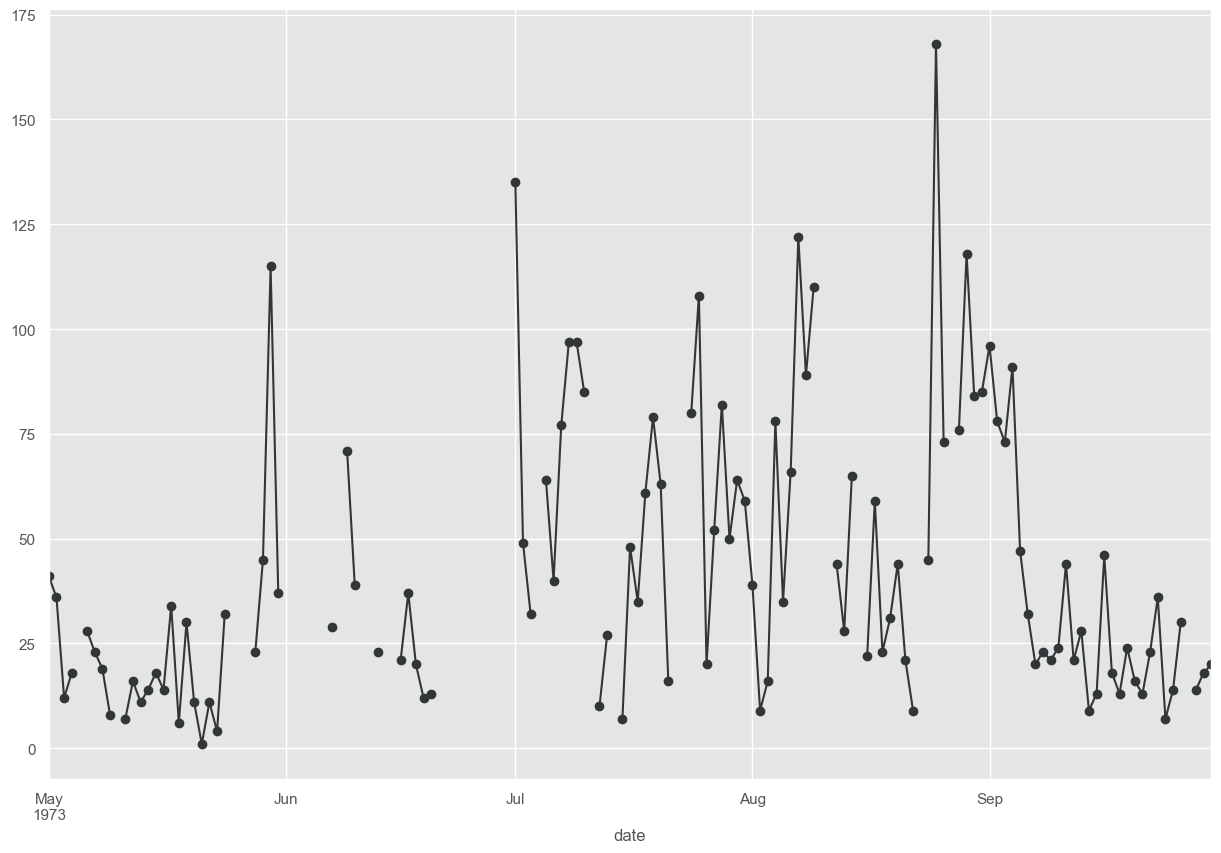

In [38]:
plt.figure(figsize=(15, 10))
(
    airquality_df.select("ozone").pipe(
        lambda df: df["ozone"].plot(color="#313638", marker="o")
    )
)
plt.show()

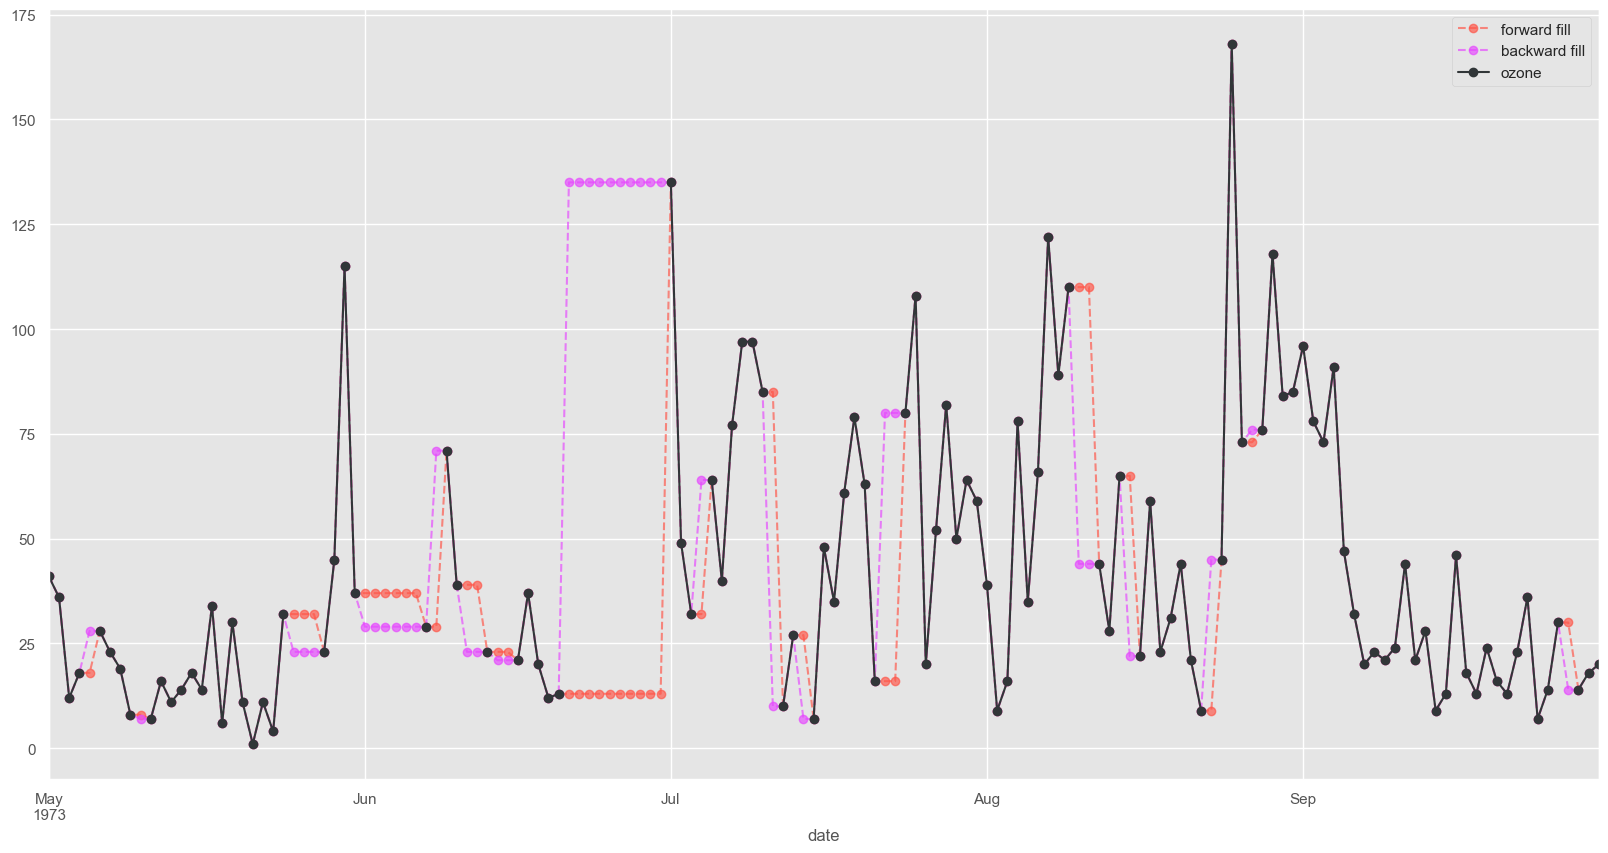

In [39]:
plt.figure(figsize=(20, 10))
(
    airquality_df.select("ozone").pipe(
        lambda df: (
            df["ozone"]
            .ffill()
            .plot(color="#ff5447", marker="o", alpha=6 / 9, linestyle="dashed"),
            df["ozone"]
            .bfill()
            .plot(color="#e647ff", marker="o", alpha=6 / 9, linestyle="dashed"),
            df["ozone"].plot(color="#313638", marker="o"),
        )
    )
)
plt.legend(["forward fill", "backward fill", "ozone"])
plt.show()

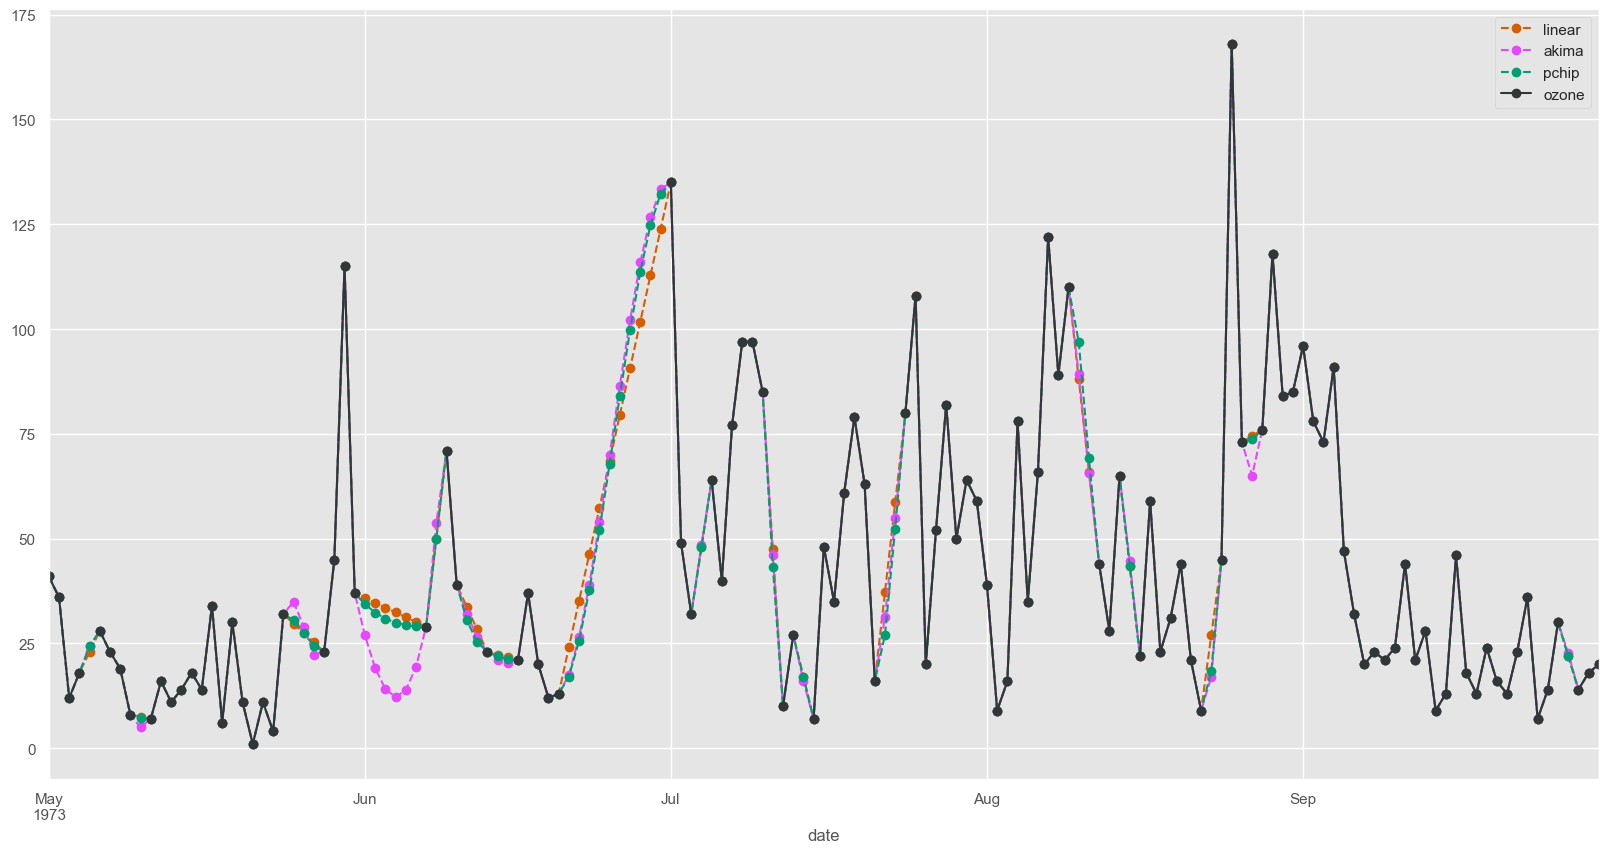

In [40]:
plt.figure(figsize=(20, 10))

(
    airquality_df.select("ozone").pipe(
        lambda df: (
            df["ozone"]
            .interpolate(method="linear")
            .plot(color="r", marker="o", linestyle="dashed"),
            df["ozone"]
            .interpolate(method="akima")
            .plot(color="#e647ff", marker="o", linestyle="dashed"),
            df["ozone"]
            .interpolate(method="pchip")
            .plot(color="g", marker="o", linestyle="dashed"),
            df["ozone"].plot(color="#313638", marker="o"),
        )
    )
)
plt.legend(["linear", "akima", "pchip", "ozone"])
plt.show()

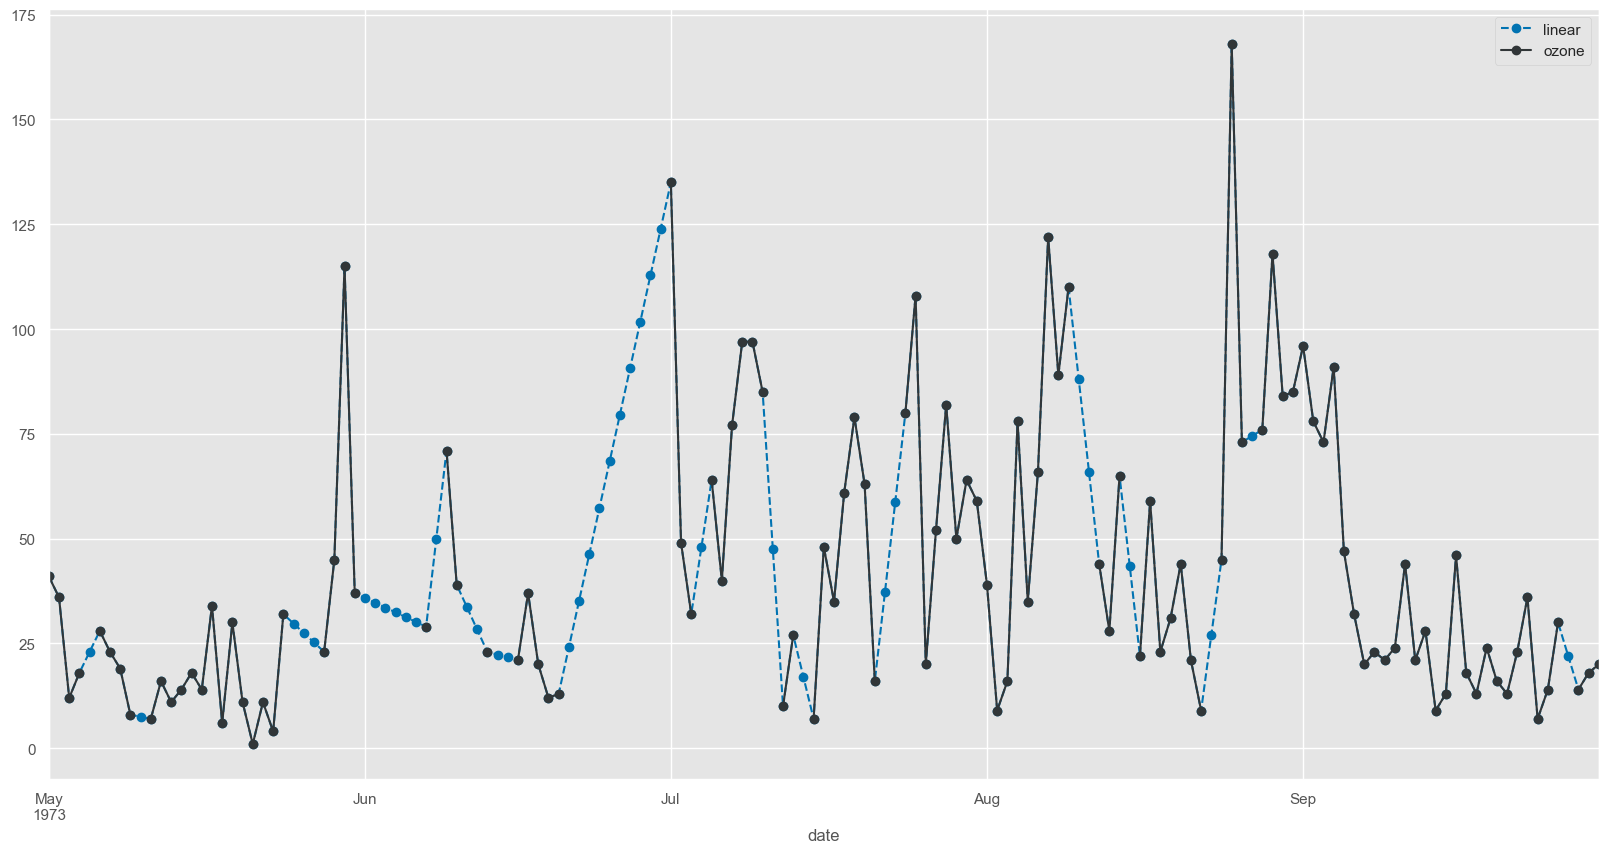

In [41]:
plt.figure(figsize=(20, 10))

(
    airquality_df.select("ozone").pipe(
        lambda df: (
            df["ozone"]
            .interpolate(method="linear")
            .plot(color="b", marker="o", linestyle="dashed"),
            df["ozone"].plot(color="#313638", marker="o"),
        )
    )
)
plt.legend(["linear", "ozone"])
plt.show()

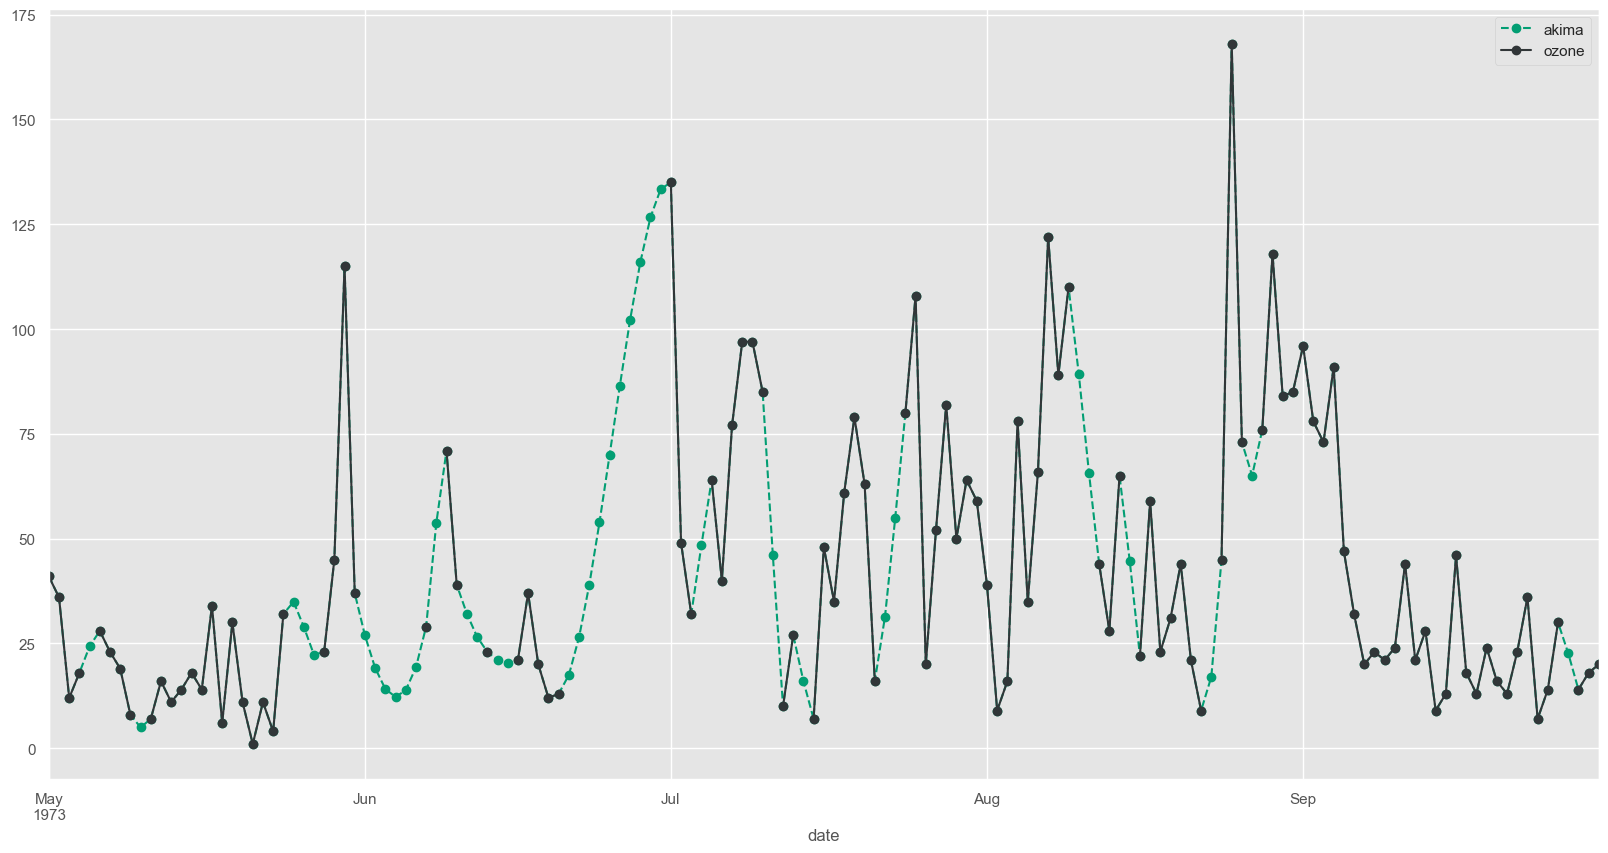

In [42]:
plt.figure(figsize=(20, 10))

(
    airquality_df.select("ozone").pipe(
        lambda df: (
            df["ozone"]
            .interpolate(method="akima")
            .plot(color="g", marker="o", linestyle="dashed"),
            df["ozone"].plot(color="#313638", marker="o"),
        )
    )
)
plt.legend(["akima", "ozone"])
plt.show()

**Métodos basados en donantes:**

- `method='linear'`: Interpolación lineal simple entre los dos puntos más cercanos.

- `method='nearest'`: Asigna el valor del punto más cercano al punto con valor faltante.

- `method='quadratic`: Interpolación cuadrática utilizando los dos puntos más cercanos y el siguiente punto más cercano en la misma dirección.

- `method='cubic`: Interpolación cúbica utilizando los dos puntos más cercanos y los dos siguientes puntos más cercanos en la misma dirección.

- `method='krogh`: Interpolación de Akima, que utiliza una función cúbica a trozos con restricciones de monotonía.

- `method='spline`: Interpolación cúbica con splines de B-spline.

**Métodos basados en modelos:**

- `method='barycentric`: Interpolación baricéntrica, que utiliza una ponderación basada en la distancia de los puntos vecinos.

- `method='polynomial`: Interpolación polinomial de orden especificado (parámetro 'order').

- `method='pchip`: Interpolación cúbica monotónica de Hermite con preservación de la forma local.
  **Otros métodos:**

- `method='index'`: Interpolación lineal usando el índice del DataFrame.

- `method='pad'`: Rellena los valores faltantes con el valor del borde más cercano (opción 'ffill' para relleno hacia adelante, 'bfill' para relleno hacia atrás).


## Imputación por algoritmo de vecinos más cercanos (KNN)

### Pasos para imputación por K-Nearest-Neighbors

[Documentacion](https://scikit-learn.org/stable/modules/neighbors.html)


In [43]:
nhanes_df

,height,weight,general_health_condition,cholesterol,pulse,age,gender,diabetes
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,66.0,Female,0
93706.0,68.0,145.0,Very good,148.0,82.0,18.0,Male,0
93707.0,NaN,NaN,Good,189.0,100.0,13.0,Male,0
93709.0,62.0,200.0,NaN,176.0,74.0,75.0,Female,0
93711.0,69.0,142.0,Very good,238.0,62.0,56.0,Male,0
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,33.0,Male,0
102953.0,65.0,218.0,Fair or,182.0,78.0,42.0,Male,0
102954.0,66.0,150.0,Good,172.0,78.0,41.0,Female,0


In [44]:
nhanes_transformed_df

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,13.0,0.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,33.0,0.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,42.0,0.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,41.0,0.0


In [45]:
knn_inputer = sklearn.impute.KNNImputer()

knn_inputer

KNNImputer()

In [46]:
nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

In [47]:
nhanes_df_knn.head(10)

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,13.0,0.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0
93712.0,2.0,1.0,68.0,135.0,182.0,68.0,18.0,0.0
93713.0,4.0,1.0,70.0,165.0,184.0,90.0,67.0,0.0
93714.0,2.0,0.0,60.0,210.0,230.0,90.0,54.0,1.0
93715.0,1.0,1.0,68.0,154.0,180.0,66.0,71.0,0.0


In [48]:
nhanes_df_knn.iloc[:, :] = knn_inputer.fit_transform(nhanes_transformed_df).round()

In [49]:
nhanes_df_knn.head(10)

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,13.0,0.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0
93712.0,2.0,1.0,68.0,135.0,182.0,68.0,18.0,0.0
93713.0,4.0,1.0,70.0,165.0,184.0,90.0,67.0,0.0
93714.0,2.0,0.0,60.0,210.0,230.0,90.0,54.0,1.0
93715.0,1.0,1.0,68.0,154.0,180.0,66.0,71.0,0.0


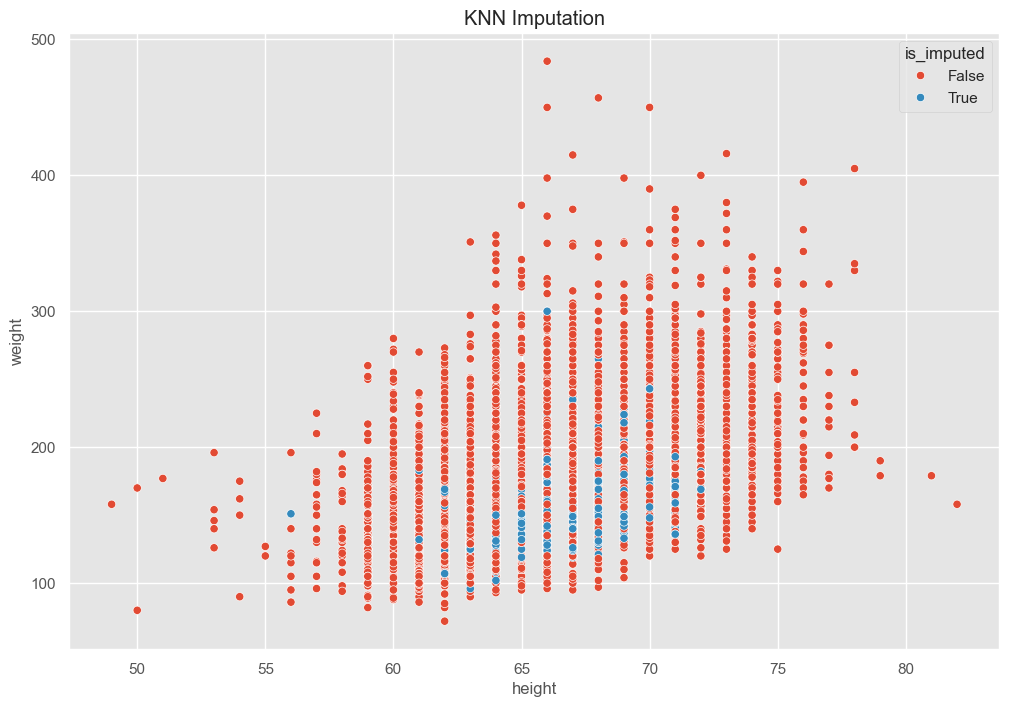

In [50]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(
                True, False, suffix="_imp", only_missing=True
            ),
        ],
        axis=1,
    ).missing.scatter_imputation_plot(x="height", y="weight")
)
plt.title("KNN Imputation")
plt.show()

### Ordenamiento por cantidad de variables faltantes


In [51]:
knn_inputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(
    ascending=True
).copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_inputer.fit_transform(
    nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True)
).round()

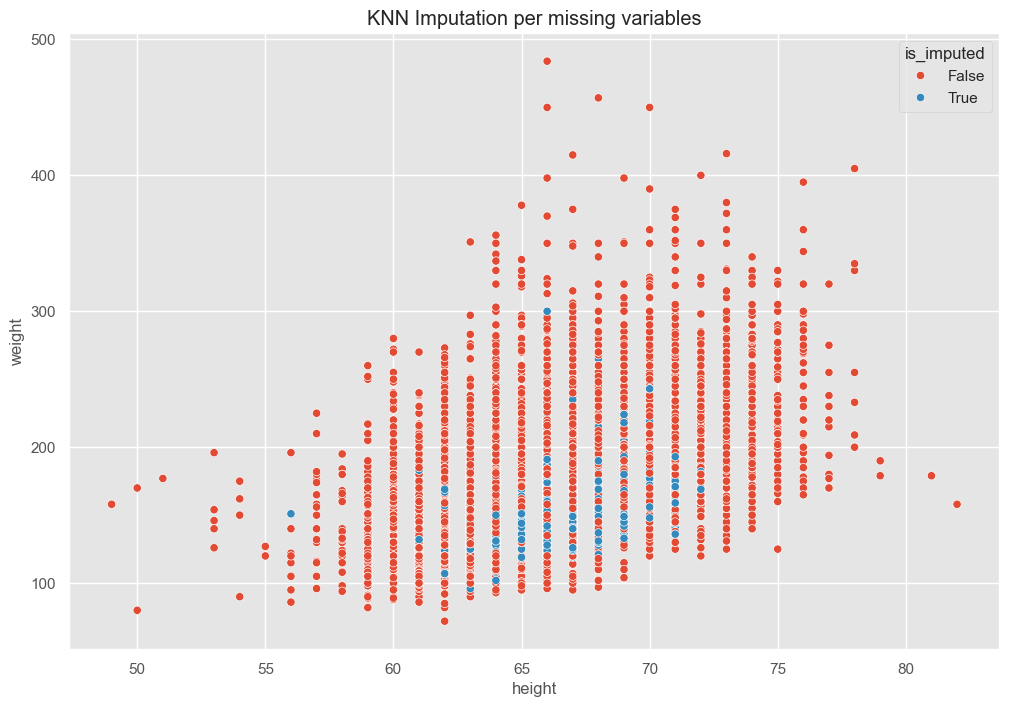

In [52]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(
                True, False, suffix="_imp", only_missing=True
            ),
        ],
        axis=1,
    ).missing.scatter_imputation_plot(x="height", y="weight")
)
plt.title("KNN Imputation per missing variables")
plt.show()

### Imputación basada en modelos


In [53]:
nhanes_model_df = (
    nhanes_df.select("height", "weight", "gender", "age")
    .sort_values(by="height", ascending=False)
    .transform_column("weight", lambda x: x.ffill(), elementwise=False)
    .missing.bind_shadow_matrix(True, False, suffix="_imp", only_missing=False)
)

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
99068.0,82.0,158.0,Male,76.0,False,False,False,False
97955.0,81.0,179.0,Male,65.0,False,False,False,False
96471.0,79.0,190.0,Male,65.0,False,False,False,False
100261.0,79.0,179.0,Female,80.0,False,False,False,False
99349.0,78.0,405.0,Male,37.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [54]:
height_ols = nhanes_model_df.pipe(
    lambda df: smf.ols(formula="height ~ weight + gender + age", data=df).fit()
)

height_ols

In [55]:
ols_imputed_values = nhanes_model_df.pipe(lambda df: df[df.height.isna()]).pipe(
    lambda df: height_ols.predict(df).round()
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [56]:
nhanes_model_df.loc[nhanes_model_df["height"].isna(), ["height"]] = ols_imputed_values

In [57]:
nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
99068.0,82.0,158.0,Male,76.0,False,False,False,False
97955.0,81.0,179.0,Male,65.0,False,False,False,False
96471.0,79.0,190.0,Male,65.0,False,False,False,False
100261.0,79.0,179.0,Female,80.0,False,False,False,False
99349.0,78.0,405.0,Male,37.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,63.0,107.0,Female,14.0,True,False,False,False
102926.0,63.0,107.0,Female,15.0,True,False,False,False
102941.0,63.0,107.0,Female,14.0,True,False,False,False


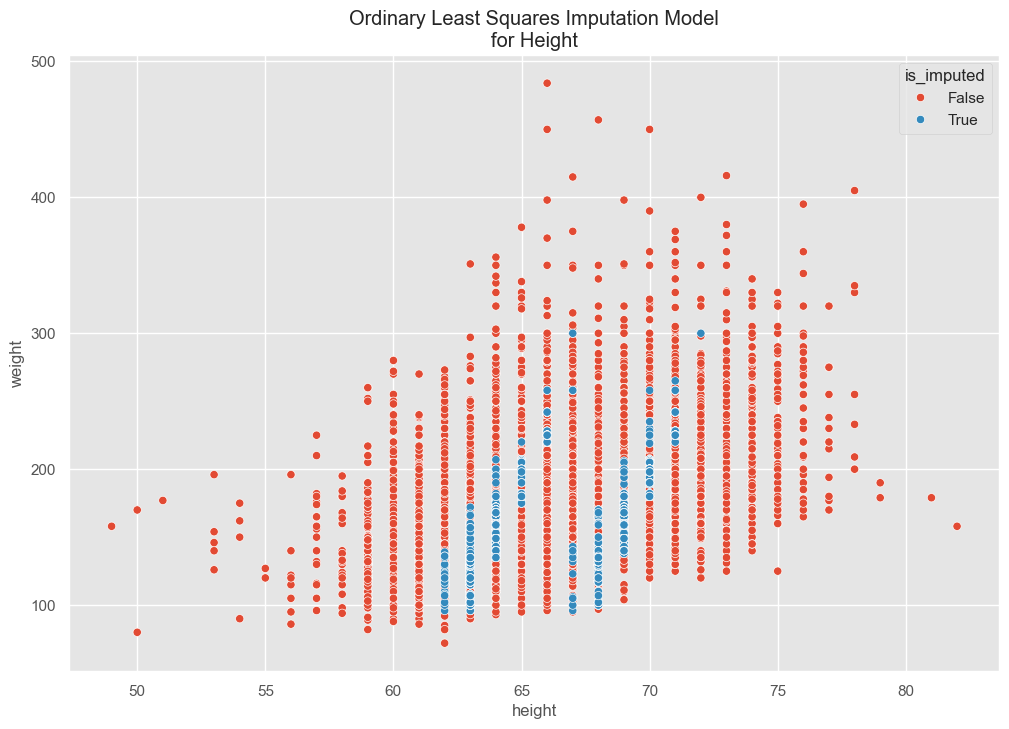

In [58]:
(nhanes_model_df.missing.scatter_imputation_plot(x="height", y="weight"))

plt.title("Ordinary Least Squares Imputation Model\nfor Height")
plt.show()

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)


In [59]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(), initial_strategy="mean", imputation_order="ascending"
)

In [60]:
nhanes_mice_df = nhanes_transformed_df.copy(deep=True)

nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_mice_df

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,2.0,1.0,70.0,200.0,189.0,100.0,13.0,0.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,33.0,0.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,42.0,0.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,41.0,0.0


In [61]:
nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(
            True, False, suffix="_imp", only_missing=True
        ),
    ],
    axis=1,
)

nhanes_mice_df

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes,height_imp,weight_imp,general_health_condition_imp,cholesterol_imp,pulse_imp
SEQN,,,,,,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0,False,False,False,False,False
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0,False,False,False,False,False
93707.0,2.0,1.0,70.0,200.0,189.0,100.0,13.0,0.0,True,True,False,False,False
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,75.0,0.0,False,False,True,False,False
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,33.0,0.0,False,False,False,False,False
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,42.0,0.0,False,False,False,False,False
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,41.0,0.0,False,False,False,False,False


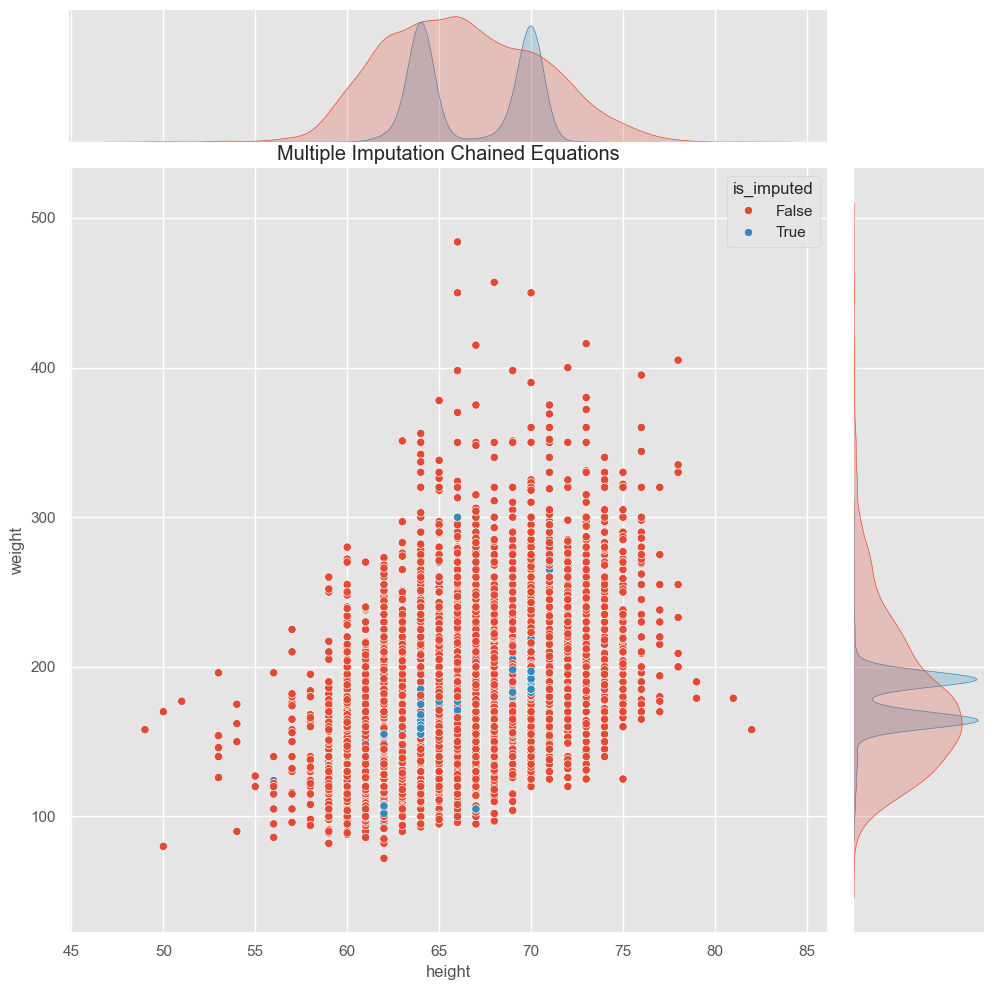

In [62]:
nhanes_mice_df.missing.scatter_imputation_plot(
    x="height", y="weight", show_marginal=True, height=10
)
plt.title("Multiple Imputation Chained Equations")
plt.show()

## Transformación inversa de los datos


In [63]:
nhanes_imputed_df = nhanes_mice_df.copy(deep=True)

In [64]:
nhanes_imputed_df[categorical_columns] = (
    categorical_transformer.named_transformers_.ordinalencoder.inverse_transform(
        X=nhanes_mice_df[categorical_columns]
    )
)

nhanes_imputed_df

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes,height_imp,weight_imp,general_health_condition_imp,cholesterol_imp,pulse_imp
SEQN,,,,,,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,66.0,0.0,False,False,False,False,False
93706.0,Very good,Male,68.0,145.0,148.0,82.0,18.0,0.0,False,False,False,False,False
93707.0,Good,Male,70.0,200.0,189.0,100.0,13.0,0.0,True,True,False,False,False
93709.0,Good,Female,62.0,200.0,176.0,74.0,75.0,0.0,False,False,True,False,False
93711.0,Very good,Male,69.0,142.0,238.0,62.0,56.0,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,Excellent,Male,72.0,180.0,201.0,96.0,33.0,0.0,False,False,False,False,False
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,42.0,0.0,False,False,False,False,False
102954.0,Good,Female,66.0,150.0,172.0,78.0,41.0,0.0,False,False,False,False,False


In [65]:
nhanes_df["general_health_condition"].value_counts()

general_health_condition
Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: count, dtype: int64

In [66]:
nhanes_imputed_df["general_health_condition"].value_counts()

general_health_condition
Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: count, dtype: int64

In [67]:
nhanes_df.missing.number_missing()

5812

In [68]:
nhanes_imputed_df.missing.number_missing()

0

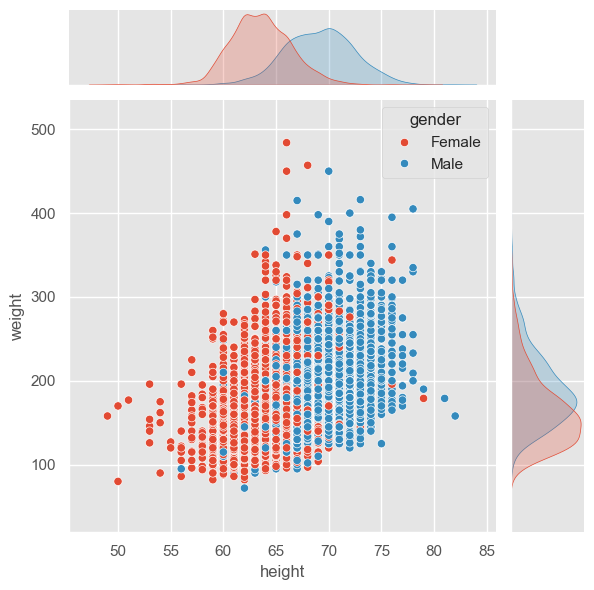

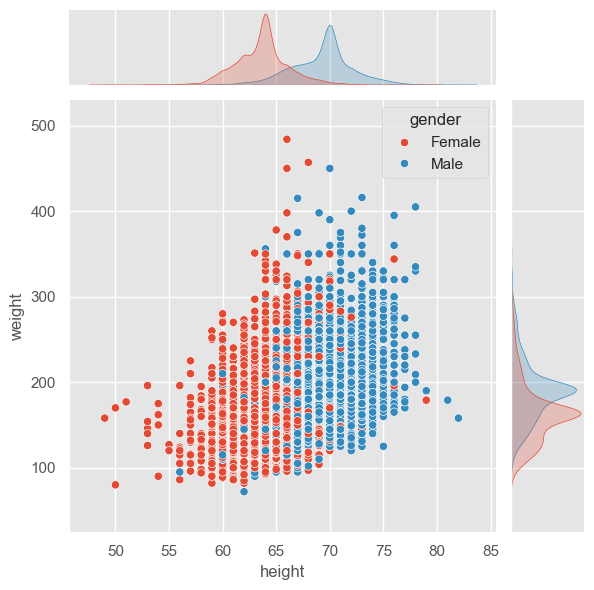

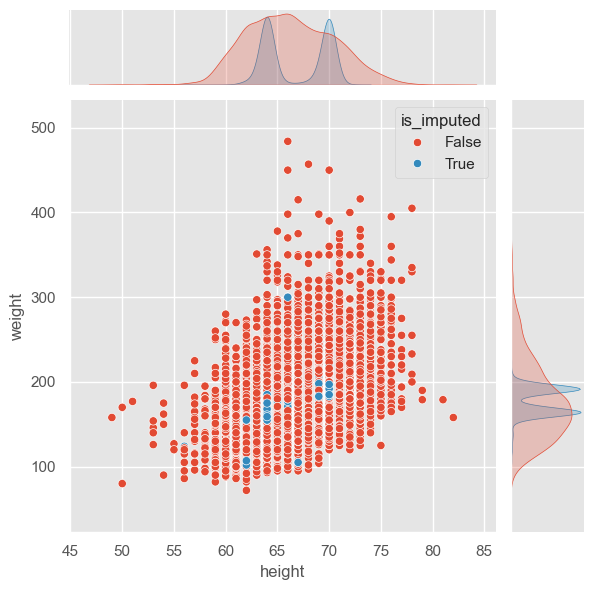

In [71]:
sns.jointplot(data=nhanes_df, x="height", y="weight", hue="gender", kind="scatter")
sns.jointplot(
    data=nhanes_imputed_df, x="height", y="weight", hue="gender", kind="scatter"
)
(
    nhanes_imputed_df.missing.scatter_imputation_plot(
        x="height", y="weight", show_marginal=True
    )
)
plt.show()